In [7]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
mpl.style.use('classic')

import baraffe_tables
from baraffe_tables.table_search import baraffe_table_search

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil

%matplotlib inline

In [8]:
mJtomSun = u.jupiterMass.to(u.solMass)
mJtoGrams = u.jupiterMass.to(u.g)

rJtorSun = u.jupiterRad.to(u.solRad)
rJtoCm = u.jupiterRad.to(u.cm)

print(mJtomSun)
print(mJtoGrams)
print(rJtorSun)
print(rJtoCm)


0.0009545942339693249
1.8981245973360504e+30
0.10276268506540176
7149200000.0


In [9]:
print(5*rJtoCm)

35746000000.0


In [10]:
#jupiter masses
Minit = np.round(np.logspace(np.log10(0.2),np.log10(20.), num=20),2)[::-1]
print(Minit)

#jupiter radii
Rinit = np.array((10.0,7.5,5.0,3.0,2.5,2.0,1.75,1.5,1.25,1.0))


[20.   15.7  12.32  9.67  7.59  5.95  4.67  3.67  2.88  2.26  1.77  1.39
  1.09  0.86  0.67  0.53  0.41  0.32  0.25  0.2 ]


In [11]:
ls .


1_created_models/                       examine_entropy_of_created_suite.ipynb
2_relaxed_models/                       relax_suite.ipynb
3_evolved_models/                       which_models_converged.ipynb
create_suite.ipynb


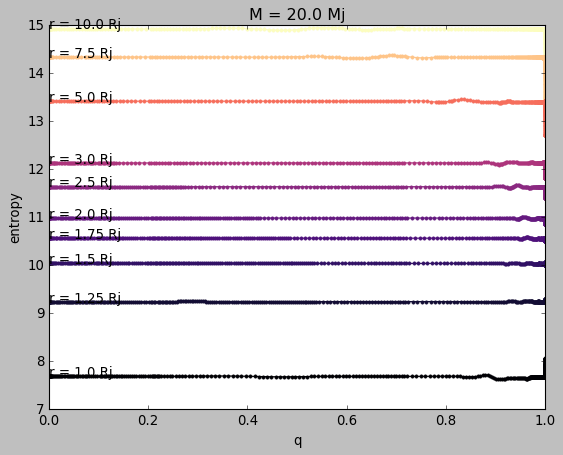

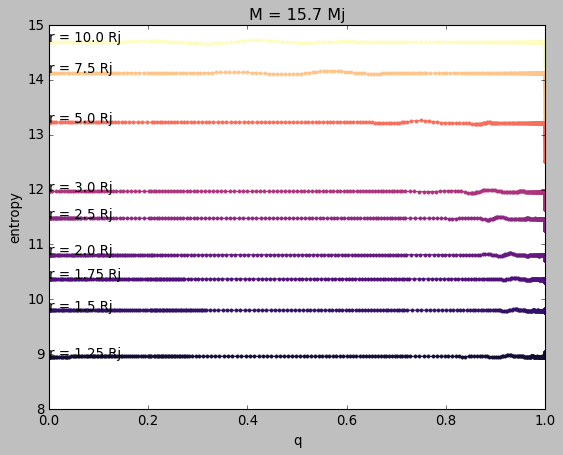

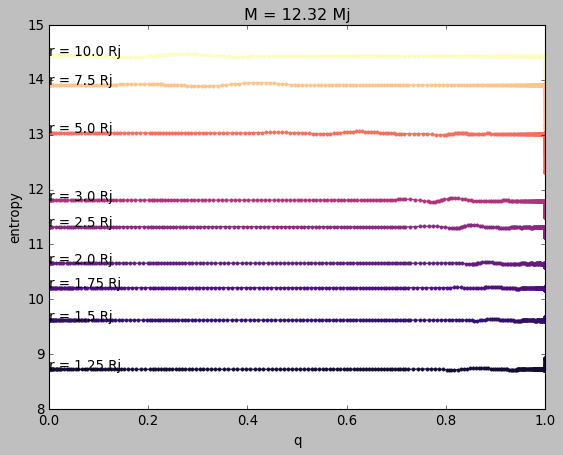

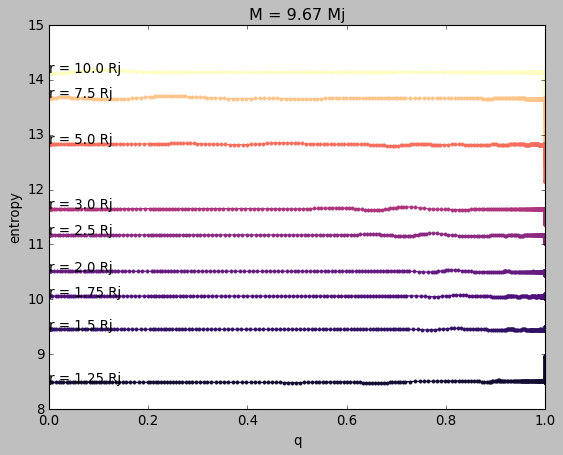

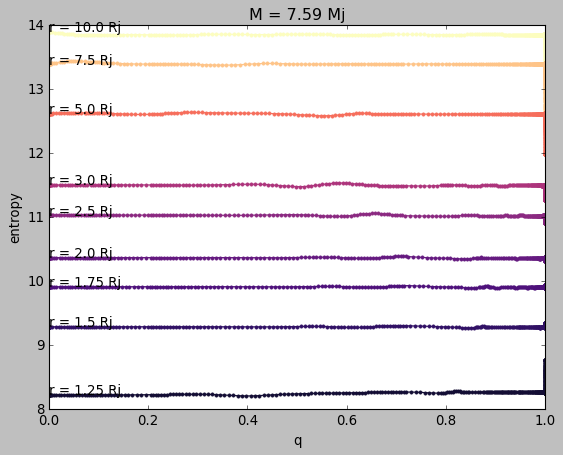

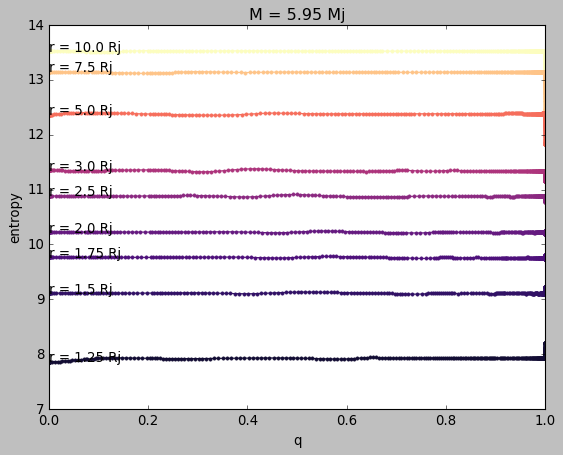

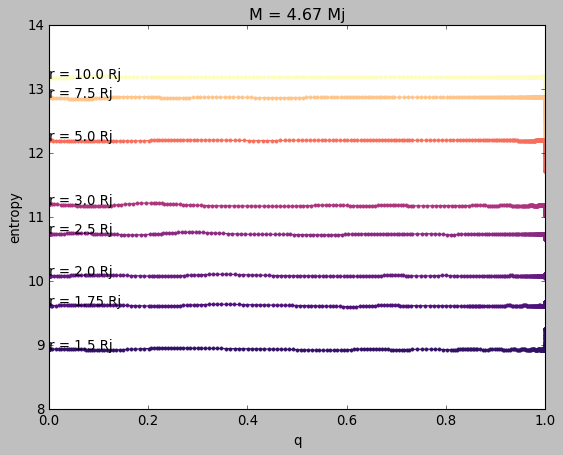

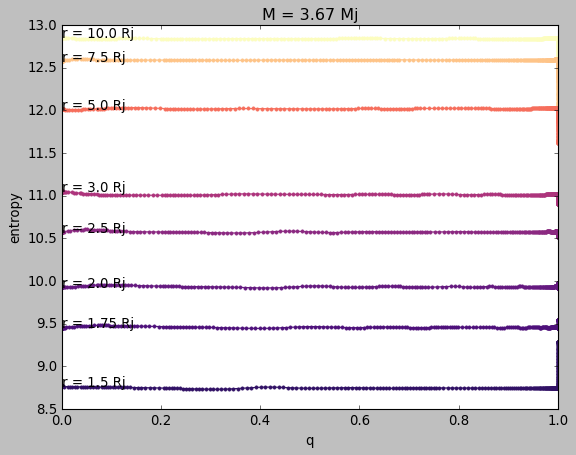

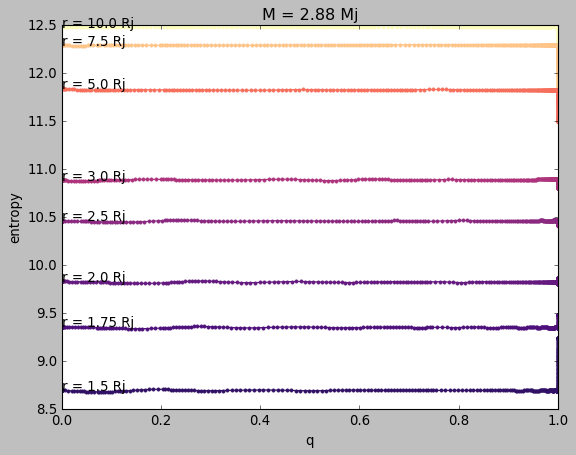

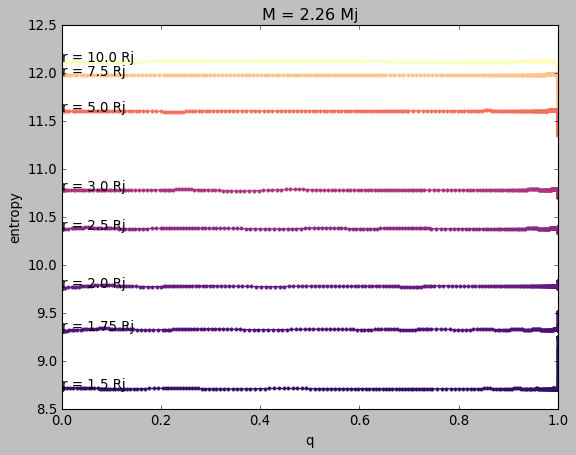

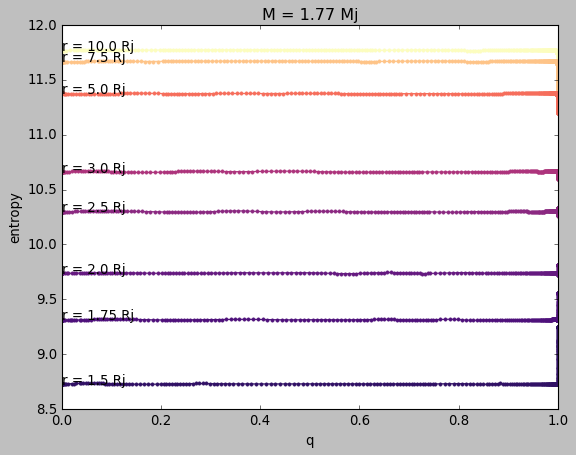

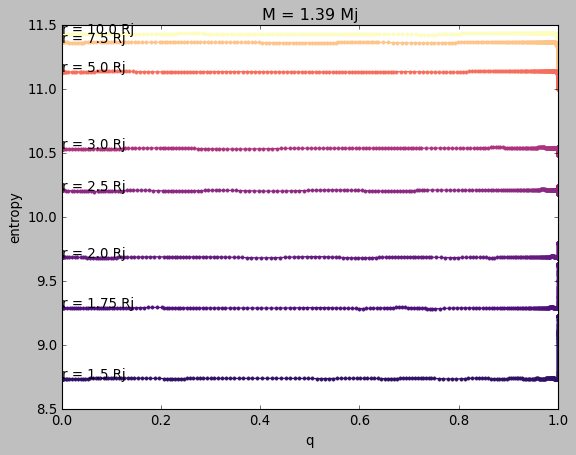

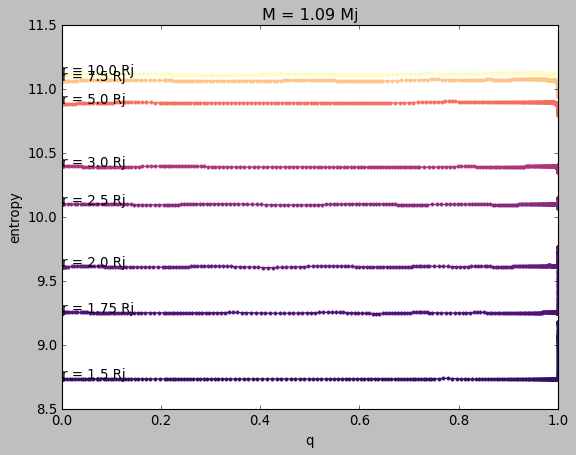

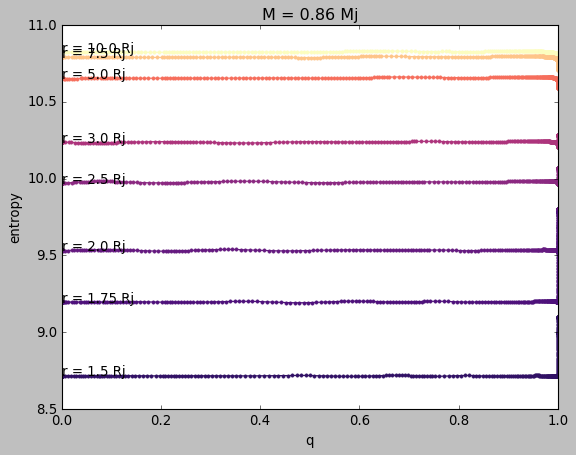

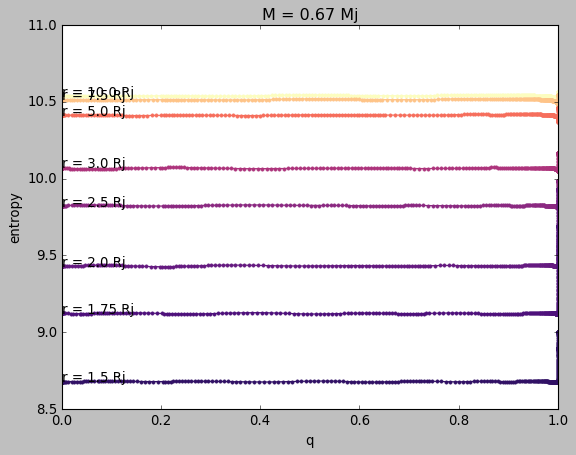

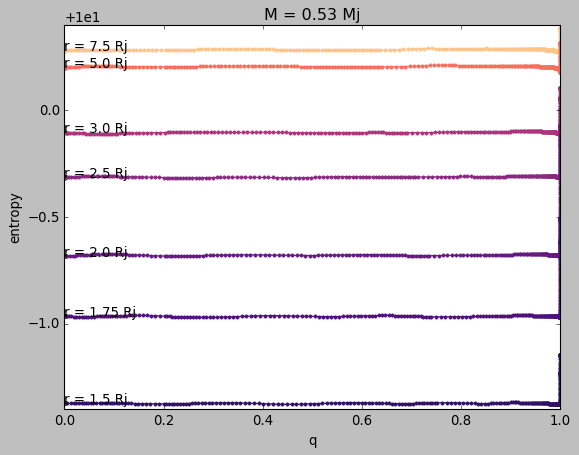

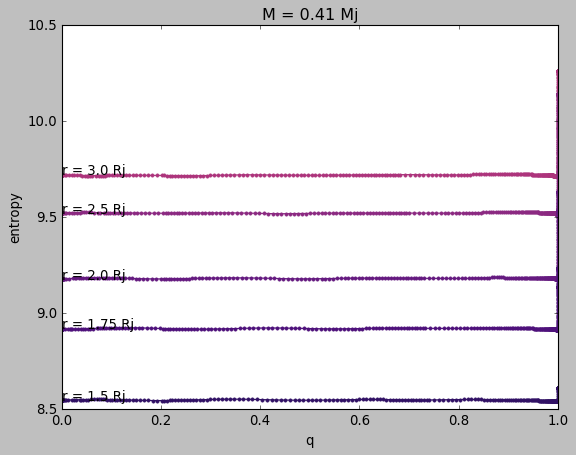

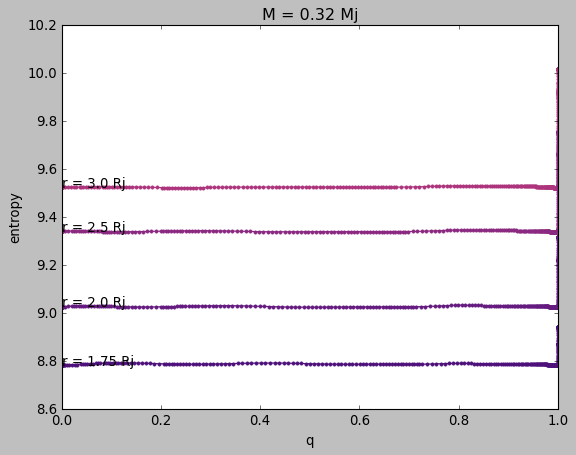

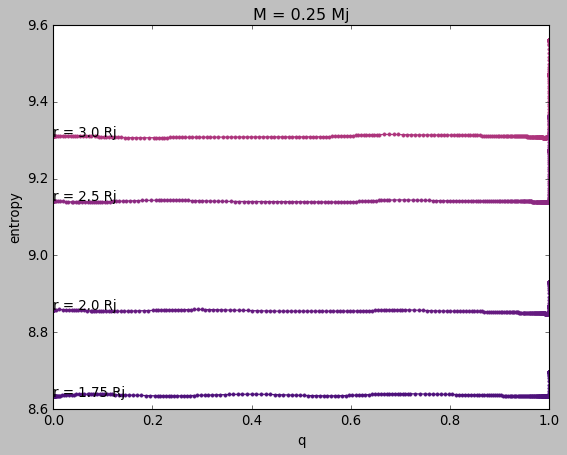

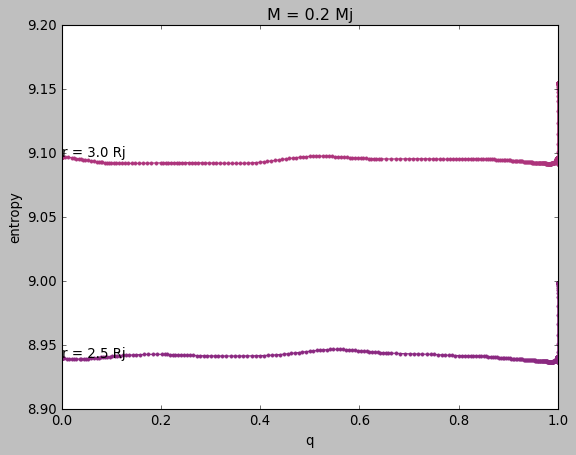

In [37]:
cm = plt.get_cmap('magma') 
cNorm  = colors.Normalize(vmin=np.log(np.min(Rinit)), vmax=np.log(np.max(Rinit)))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

sMedian = np.zeros((len(Minit),len(Rinit)))
rMax = np.zeros((len(Minit), len(Rinit)))

for i, m in enumerate(Minit): 
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    for j, r in enumerate(Rinit):
        colorVal = scalarMap.to_rgba(np.log(r))
        
        create_profile_filename = "./1_created_models/planet_create_{0}_Mj_{1}_Rj.profile".format(m, r)
        try:
            profile = Table.read(create_profile_filename, format="ascii", header_start=4, data_start=5)
            ax.plot(profile['q'], profile['entropy'],color=colorVal, marker='.')
            ax.text(profile['q'][-1], profile['entropy'][-1],s="r = {0} Rj".format(r))
            sMedian[i,j] = np.median(profile['entropy'])
            rMax[i,j] = 10**profile['logR'][0] * u.solRad.to(u.jupiterRad)
        except FileNotFoundError:
            sMedian[i,j] = np.nan
            rMax[i,j] = np.nan
            continue
    
    ax.set_title("M = {0} Mj".format(m))
    ax.set_xlabel('q')
    ax.set_ylabel('entropy')
    #ax.set_ylim(8.75,11.25)
    
    plt.show()



In [38]:
print(np.shape(sMedian))
print(sMedian)

(20, 10)
[[14.91350645 14.32542579 13.40139372 12.12634827 11.62528996 10.97341704
  10.55457546 10.0305651   9.23283172  7.67188088]
 [14.68933303 14.11979067 13.21257249 11.96430892 11.4686214  10.81042351
  10.36323321  9.79252699  8.95360556         nan]
 [14.43157983 13.90446419 13.01876298 11.79607735 11.31404741 10.65193995
  10.2085959   9.61937339  8.72349531         nan]
 [14.14266646 13.65909802 12.82173325 11.64542687 11.16604931 10.50385524
  10.05288199  9.44620469  8.50137295         nan]
 [13.84873035 13.38887565 12.60850614 11.4941643  11.02087179 10.35698398
   9.90574948  9.27917249  8.25712353         nan]
 [13.52146841 13.13630386 12.38197908 11.33865698 10.8780203  10.22284898
   9.75671214  9.10610248  7.92907952         nan]
 [13.18723397 12.86820567 12.19503924 11.1777969  10.72949523 10.07972409
   9.61577151  8.92918325         nan         nan]
 [12.83971367 12.58868379 12.01758288 11.01167686 10.5729124   9.93278931
   9.45562126  8.74501457         nan     

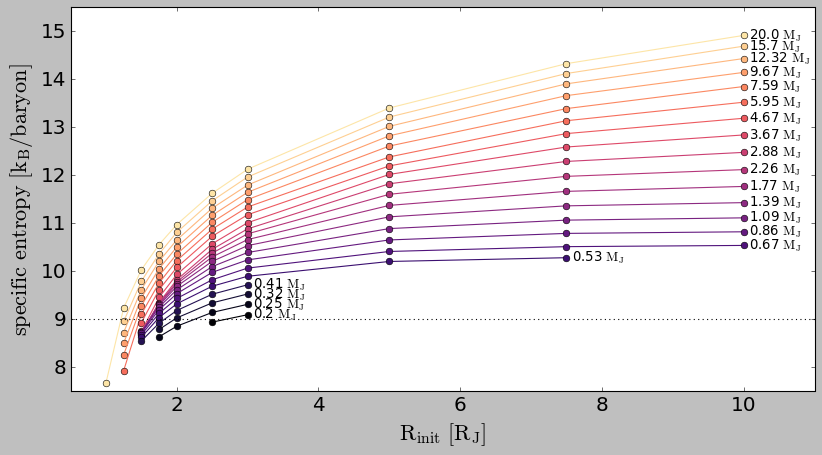

In [39]:
cm = plt.get_cmap('magma') 
cNorm  = colors.Normalize(vmin=np.log(np.min(Minit)), vmax=np.log(np.max(Minit))+0.25)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(1,1,figsize=(12,6))
for i, m in enumerate(Minit): 
    colorVal = scalarMap.to_rgba(np.log(m))
    ax.plot(Rinit,sMedian[i],marker='o',color=colorVal,mec='k',ls='-')
    ax.text(Rinit[~np.isnan(sMedian[i])][0]+0.075,sMedian[i][~np.isnan(sMedian[i])][0]-0.075,s=r"{0}".format(m)+r" $\mathrm{M}_\mathrm{J}$")

ax.axhline(9,color='k',ls=':')
ax.set_xlabel(r"$\mathrm{R}_\mathrm{init}\ [\mathrm{R}_\mathrm{J}]$",fontsize=20)
ax.set_ylabel(r"$\mathrm{specific}\ \mathrm{entropy}\ [\mathrm{k}_\mathrm{B}/\mathrm{baryon}]$",fontsize=20)
ax.set_xlim(0.5,11)
ax.set_ylim(7.5,15.5)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()


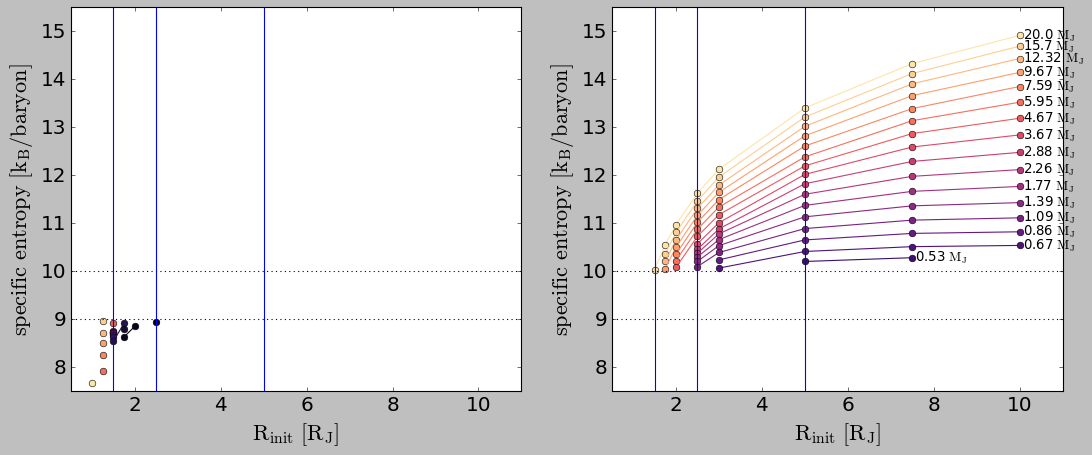

In [40]:
coldStartUpperLimit = 9.
hotStartLowerLimit = 10.

fig, axes = plt.subplots(1,2,figsize=(16,6))
for i, m in enumerate(Minit): 
    colorVal = scalarMap.to_rgba(np.log(m))
    axes[0].plot(Rinit[sMedian[i] <= coldStartUpperLimit],sMedian[i][sMedian[i] <= coldStartUpperLimit],marker='o',color=colorVal,mec='k',ls='-')
    #axes[0].text(Rinit[~np.isnan(sMedian[i]) & (sMedian[i] <= coldStartUpperLimit)][0]+0.075,sMedian[i][~np.isnan(sMedian[i]) & (sMedian[i] <= coldStartUpperLimit)][0]-0.075,s=r"{0}".format(m)+r" $\mathrm{M}_\mathrm{J}$")

    try:
        axes[1].plot(Rinit[sMedian[i] >= hotStartLowerLimit],sMedian[i][sMedian[i] >=hotStartLowerLimit],marker='o',color=colorVal,mec='k',ls='-')
        axes[1].text(Rinit[~np.isnan(sMedian[i]) & (sMedian[i] >= hotStartLowerLimit)][0]+0.075,sMedian[i][~np.isnan(sMedian[i]) & (sMedian[i] >= hotStartLowerLimit)][0]-0.075,s=r"{0}".format(m)+r" $\mathrm{M}_\mathrm{J}$")
    except IndexError:
        continue

for ax in axes:
    ax.axhline(coldStartUpperLimit,color='k',ls=':')
    ax.axhline(hotStartLowerLimit,color='k',ls=':')
    ax.set_xlabel(r"$\mathrm{R}_\mathrm{init}\ [\mathrm{R}_\mathrm{J}]$",fontsize=20)
    ax.set_ylabel(r"$\mathrm{specific}\ \mathrm{entropy}\ [\mathrm{k}_\mathrm{B}/\mathrm{baryon}]$",fontsize=20)
    ax.set_xlim(0.5,11)
    ax.set_ylim(7.5,15.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.axvline(2.5)
    ax.axvline(1.5)
    ax.axvline(5)
plt.show()


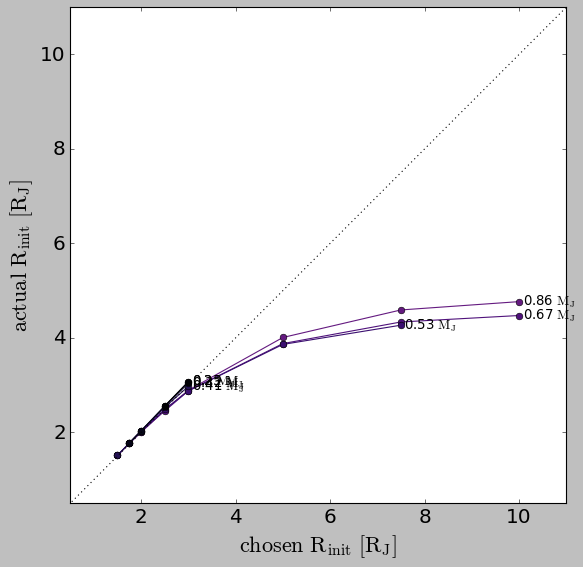

In [42]:
# check that radii converge to desired Rinit
cm = plt.get_cmap('magma') 
cNorm  = colors.Normalize(vmin=np.log(np.min(Minit)), vmax=np.log(np.max(Minit))+0.25)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(1,1,figsize=(8,8))
for i, m in enumerate(Minit): 
    colorVal = scalarMap.to_rgba(np.log(m))
    #for j, r in enumerate(Rinit):
    #    if rMax[i][j] > r and r > 4:
    #        print(m)
    if m < 1.0:
        ax.plot(Rinit,rMax[i],marker='o',color=colorVal,mec='k',ls='-')
        ax.text(Rinit[~np.isnan(rMax[i])][0]+0.075,rMax[i][~np.isnan(rMax[i])][0]-0.075,s=r"{0}".format(m)+r" $\mathrm{M}_\mathrm{J}$")

rs = np.linspace(0,12,3)
ax.plot(rs,rs,color='k',ls=':')
ax.set_xlabel(r"$\mathrm{chosen}\ \mathrm{R}_\mathrm{init}\ [\mathrm{R}_\mathrm{J}]$",fontsize=20)
ax.set_ylabel(r"$\mathrm{actual}\ \mathrm{R}_\mathrm{init}\ [\mathrm{R}_\mathrm{J}]$",fontsize=20)
ax.set_xlim(0.5,11)
ax.set_ylim(0.5,11)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_aspect('equal')

plt.show()


# see if the relax_composition step affected the entropy of the model 
## (for an abbreviated subset of models)

In [5]:
# for now: abbreviated list to see if the relax_composition step affects the entropy
Minit = np.array((20.0, 9.67, 4.67, 1.09))
Rinit = np.array((5.0, 2.5, 1.0))
#overall metallicities
Zinit = np.array((0.01,0.025,0.05,0.1))

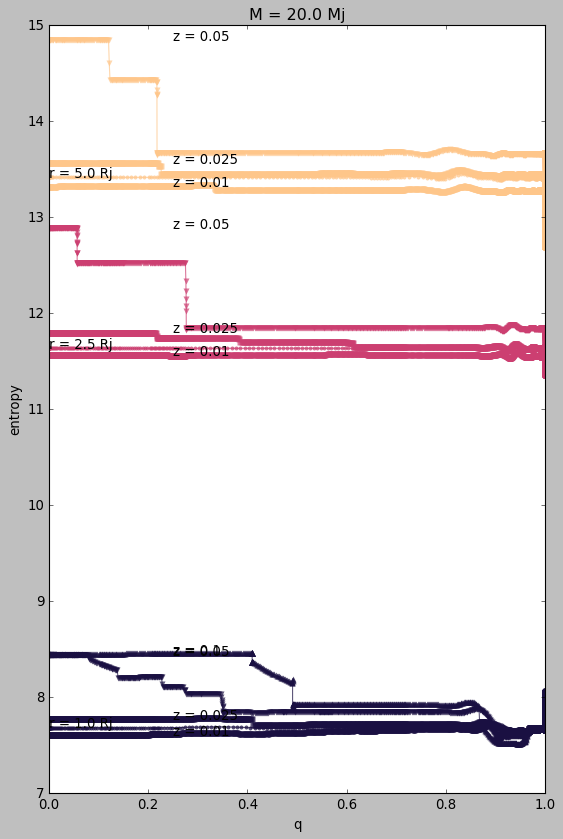

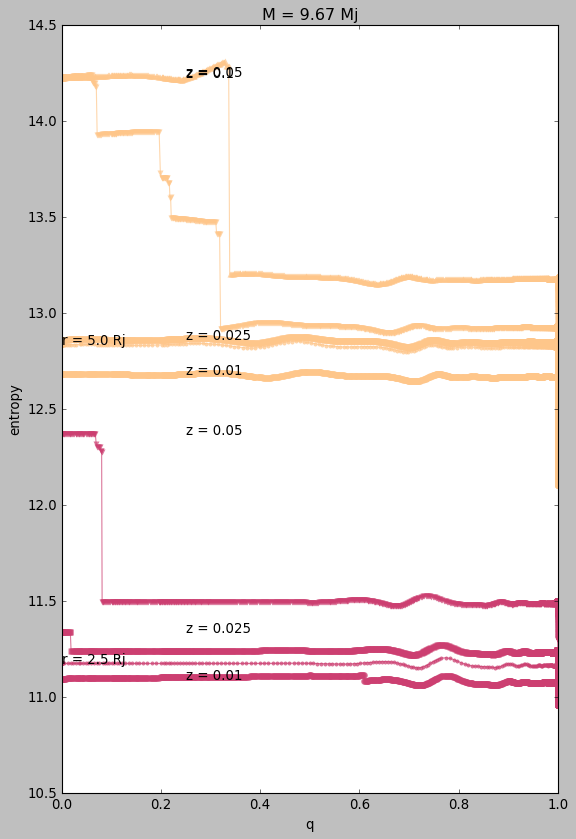

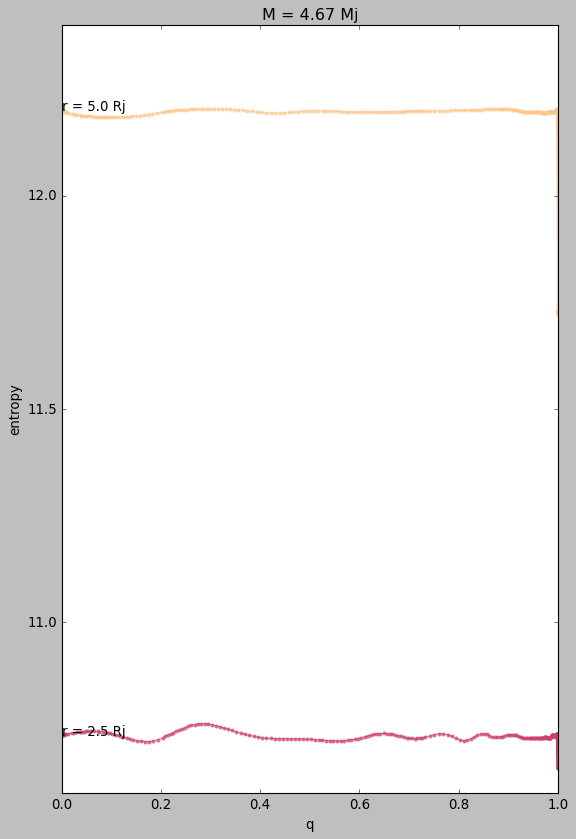

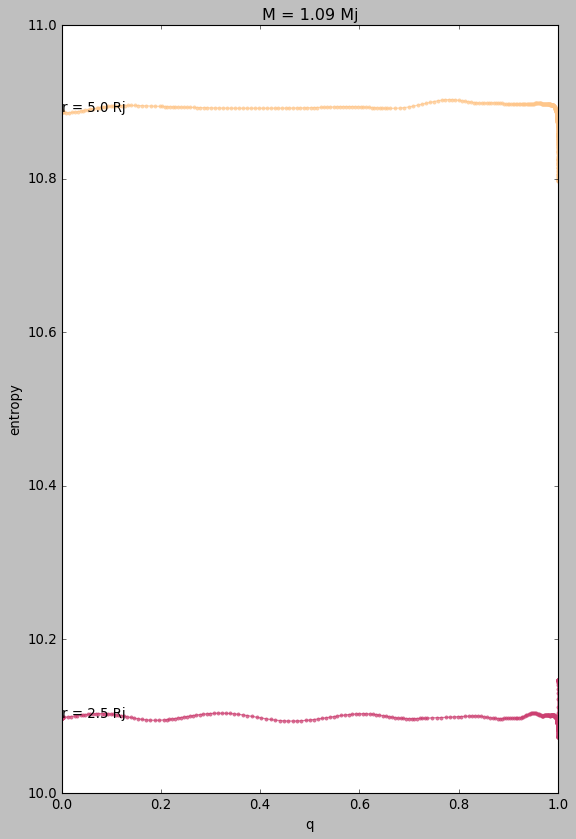

In [6]:
cm = plt.get_cmap('magma') 
cNorm  = colors.Normalize(vmin=np.log(np.min(Rinit))-0.25, vmax=np.log(np.max(Rinit))+0.25)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

create_models_dir = '/Users/emily/Documents/astro/giant_planets/science_runs/1_created_models'
relax_models_dir = '/Users/emily/Documents/astro/giant_planets/science_runs/2_relaxed_models'
comp_dir = 'exponential_relaxed'
comp = 'exponential'

markers = ['o','s','v','^']

for i, m in enumerate(Minit):
    fig, ax = plt.subplots(1,1,figsize=(8,12))
    for j, r in enumerate(Rinit):
        colorVal = scalarMap.to_rgba(np.log(r))
        try:
            create_profile_filename = "{0}/planet_create_{1}_Mj_{2}_Rj.profile".format(create_models_dir, m, r)
            create_profile = Table.read(create_profile_filename, format="ascii", header_start=4, data_start=5)
            
            ax.plot(create_profile['q'], create_profile['entropy'],color=colorVal, marker='.',alpha=0.7)
            ax.text(create_profile['q'][-1], create_profile['entropy'][-1],s="r = {0} Rj".format(r))
        except FileNotFoundError:
            continue

        for k, z in enumerate(Zinit):
            try:
                relax_profile_filename = "{0}/{1}/planet_relax_{2}_Mj_{3}_Rj_zbar={4}_{5}.profile".format(relax_models_dir, comp_dir, m, r, z, comp)
                relax_profile = Table.read(relax_profile_filename, format="ascii", header_start=4, data_start=5)
            
                ax.plot(relax_profile['q'], relax_profile['entropy'],color=colorVal, marker=markers[k],mec='None',alpha=0.7)
                ax.text(relax_profile['q'][-1]+0.25, relax_profile['entropy'][-1],s="z = {0}".format(z))
            except FileNotFoundError:
                continue
        
            
    ax.set_title("M = {0} Mj".format(m))
    ax.set_xlabel('q')
    ax.set_ylabel('entropy')
    
    plt.show()